In [7]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os, sys, subprocess, json, argparse
from itertools import product


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

dir_root = ''
# If using google colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    dir_root = '/content/drive/MyDrive/Colab Notebooks/ESE546/hw4'

print("dir_root:", dir_root)

device: cuda
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
dir_root: /content/drive/MyDrive/Colab Notebooks/ESE546/hw4


In [9]:
# Define the dataset directory
data_dir = os.path.join(dir_root, 'data')
print(data_dir)

if not os.path.exists(os.path.join(data_dir, 'cifar-10-batches-py')):
    download = True
    print('Dataset not found, downloading...')
else:
    download = False
    print('Dataset found, not downloading.')

# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=download, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=download, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/content/drive/MyDrive/Colab Notebooks/ESE546/hw4/data
Dataset found, not downloading.


In [10]:
# File allcnn.py provided by Prof. Pratik Chaudhari
# at https://gist.github.com/pratikac/68d6d94e4739786798e90691fb1a581b

class View(nn.Module):
    def __init__(self, o):
        super().__init__()
        self.o = o

    def forward(self, x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2=192):
        super().__init__()
        d = 0.5

        def convbn(ci, co, ksz, s=1, pz=0):
            return nn.Sequential(
                nn.Conv2d(ci, co, ksz, stride=s, padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3, c1, 3, 1, 1),
            convbn(c1, c1, 3, 1, 1),
            convbn(c1, c1, 3, 2, 1),
            nn.Dropout(d),
            convbn(c1, c2, 3, 1, 1),
            convbn(c2, c2, 3, 1, 1),
            convbn(c2, c2, 3, 2, 1),
            nn.Dropout(d),
            convbn(c2, c2, 3, 1, 1),
            convbn(c2, c2, 3, 1, 1),
            convbn(c2, 10, 1, 1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)


In [11]:
# Weight decay = 1e-3
# SGD with Nesterov’s momentum of 0.9
# Dropout = 0.5
# Learning rate starts with eta_0 = 1e-5,
# then eta_tp1 = 1.1 * eta_t or 1.05 * eta_t (t <= 100)

# First train 100 iters
# Record the average training loss of each mini-batch separately and the learning rate that was used for it for about 100 iterations.
# Plot the training loss (Y-axis) as a function of the learning rate (X-axis); use a log-scale for the X-axis.

def learning_rate_schedule(optimizer, rate=1.1):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= rate

def train(
    net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot, logger
):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    learning_rates = []

    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 130 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Learning Rate: {:.3g}, Loss: {:.4f}".format(
                        epoch + 1,
                        epochs,
                        i + 1,
                        total_step,
                        optimizer.param_groups[0]["lr"],
                        loss.item(),
                    )
                )
            if plot:
                info = {("loss_" + model_name): loss.item()}

                for tag, value in info.items():
                    logger.add_scalar(tag, value, overall_step + 1)

        # Check if NaN exists, if so, early stop
        if np.isnan(running_loss):
            print("NaN detected, early stopping")
            break

        # Record and update learning rate every epoch
        learning_rates.append(optimizer.param_groups[0]["lr"])
        learning_rate_schedule(optimizer, rate=1.1)

        train_loss_values.append(running_loss)
        train_error.append(100 - 100 * correct / total)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Validation Loss: {:.4f},'.format(val_running_loss), 'Validation Error {} %'.format(100 - 100 * correct / total))
        val_error.append(100 - 100 * correct / total)
        val_loss_values.append(val_running_loss)

    return val_error, val_loss_values, train_error, train_loss_values, learning_rates

In [12]:
# Weight decay = 1e-3
# SGD with Nesterov’s momentum of 0.9
# Dropout = 0.5
# Learning rate starts with eta_0 = 1e-5,
# then eta_tp1 = 1.1 * eta_t or 1.05 * eta_t (t <= 100)

model_path_100 = os.path.join(dir_root, 'runs/hw4p3_model_100_epoch.pt')

TRAIN_FLAG = True

if not os.path.exists(model_path_100) or TRAIN_FLAG:
    model = allcnn_t().to(device)
    epochs = 100
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-3, nesterov=True)
    logger_1 = SummaryWriter(os.path.join(dir_root, "runs/cnn_experiment"))

    val_error, val_loss_values, train_error, train_loss_values, learning_rates = train(
        model,
        optimizer,
        criterion,
        trainloader,
        testloader,
        epochs,
        "cnn_curve_100",
        True,
        logger_1,
    )

    torch.save(model, model_path_100)

    np.save(os.path.join(dir_root, 'runs/train_error_100.npy'), np.array(train_error))
    np.save(os.path.join(dir_root, 'runs/train_loss_values_100.npy'), np.array(train_loss_values))
    np.save(os.path.join(dir_root, 'runs/val_error_100.npy'), np.array(val_error))
    np.save(os.path.join(dir_root, 'runs/val_loss_values_100.npy'), np.array(val_loss_values))
    np.save(os.path.join(dir_root, 'runs/learning_rates_100.npy'), np.array(learning_rates))
else:
    print(f"Model already exists at {model_path_100}, skipping training.")

Num parameters:  1667166
Epoch [1/100], Step [130/391], Learning Rate: 1e-05, Loss: 2.2885
Epoch [1/100], Step [260/391], Learning Rate: 1e-05, Loss: 2.2593
Epoch [1/100], Step [390/391], Learning Rate: 1e-05, Loss: 2.2976
Validation Loss: 181.7598, Validation Error 88.59 %
Epoch [2/100], Step [130/391], Learning Rate: 1.1e-05, Loss: 2.1832
Epoch [2/100], Step [260/391], Learning Rate: 1.1e-05, Loss: 2.1283
Epoch [2/100], Step [390/391], Learning Rate: 1.1e-05, Loss: 2.0770
Validation Loss: 165.0128, Validation Error 75.88 %
Epoch [3/100], Step [130/391], Learning Rate: 1.21e-05, Loss: 2.0678
Epoch [3/100], Step [260/391], Learning Rate: 1.21e-05, Loss: 1.9974
Epoch [3/100], Step [390/391], Learning Rate: 1.21e-05, Loss: 1.9709
Validation Loss: 152.7725, Validation Error 69.37 %
Epoch [4/100], Step [130/391], Learning Rate: 1.33e-05, Loss: 2.0233
Epoch [4/100], Step [260/391], Learning Rate: 1.33e-05, Loss: 1.8907
Epoch [4/100], Step [390/391], Learning Rate: 1.33e-05, Loss: 1.8090
Val

In [21]:
# Load the npy files for plotting
train_error_100 = np.load(os.path.join(dir_root, 'runs/train_error_100.npy'))
train_loss_values_100 = np.load(os.path.join(dir_root, 'runs/train_loss_values_100.npy'))
val_error_100 = np.load(os.path.join(dir_root, 'runs/val_error_100.npy'))
val_loss_values_100 = np.load(os.path.join(dir_root, 'runs/val_loss_values_100.npy'))
learning_rates_100 = np.load(os.path.join(dir_root, 'runs/learning_rates_100.npy'))

print(len(train_error_100), len(train_loss_values_100), len(val_error_100), len(val_loss_values_100), len(learning_rates_100))

96 96 96 96 97


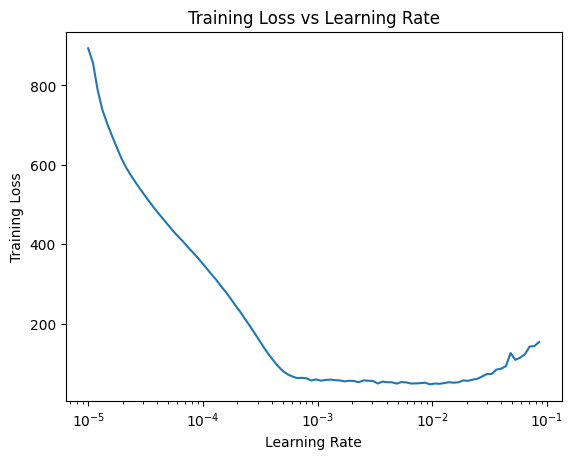

In [32]:
# Since these might be of different length, we'll extract the first min(lengths) elements
min_length = min(len(train_error_100), len(train_loss_values_100), len(val_error_100), len(val_loss_values_100), len(learning_rates_100))
train_error_100 = train_error_100[:min_length]
train_loss_values_100 = train_loss_values_100[:min_length]
val_error_100 = val_error_100[:min_length]
val_loss_values_100 = val_loss_values_100[:min_length]
learning_rates_100 = learning_rates_100[:min_length]

# Plot the training loss (Y-axis) as a function of the learning rate (X-axis); use a log-scale for the X-axis.
plt.figure()
plt.plot(learning_rates_100, train_loss_values_100)
plt.xscale('log')
plt.ylabel('Training Loss')
plt.xlabel('Learning Rate')
plt.title('Training Loss vs Learning Rate')
plt.show()

In [33]:
# Identify the minimum of training loss
# The corresponding learning rate - eta_star
eta_star = learning_rates_100[np.argmin(train_loss_values_100)]

print(f"Minimum training loss: {np.min(train_loss_values_100)}")
print(f"Corresponding learning rate: {eta_star}")


Minimum training loss: 47.16615069657564
Corresponding learning rate: 0.009555938177273274


In [34]:
# Then, use cosine learning rate schedule with a warmup
# \eta(t) = 1e-4 + t / T * eta_max, if t <= T0
# \eta(t) = eta_max * cos(pi / 2 * (t - T0) / (T - T0)) + 1e-6, if T0 < t <= T
# with eta_max = eta_star / 10, 100 epochs, T0 = T / 5
# Compute the validation loss and error after every epoch.

eta_max = eta_star / 10

def learning_rate_schedule(optimizer, t, T, eta_max=eta_max):
    T0 = T / 5
    if t <= T0:
        lr_new = 1e-4 + t / T0 * eta_max
    elif T0 < t <= T:
        lr_new = eta_max * np.cos(np.pi / 2 * (t - T0) / (T - T0)) + 1e-6
    else:  # do nothing and don't update the learning rate
        return

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_new


def train_eta_max(
    net,
    optimizer,
    criterion,
    train_loader,
    test_loader,
    epochs,
    model_name,
    plot,
    logger,
):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    learning_rates = []

    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0

        learning_rate_schedule(optimizer, epoch + 1, epochs, eta_max)

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 130 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Learning Rate: {:.3g}, Loss: {:.4f}".format(
                        epoch + 1,
                        epochs,
                        i + 1,
                        total_step,
                        optimizer.param_groups[0]["lr"],
                        loss.item(),
                    )
                )
            if plot:
                info = { ('loss_' + model_name): loss.item() }

                for tag, value in info.items():
                    logger.add_scalar(tag, value, overall_step+1)

        # Check if NaN exists, if so, early stop
        if np.isnan(running_loss):
            print("NaN detected, early stopping")
            break

        # Record learning rate every epoch
        learning_rates.append(optimizer.param_groups[0]["lr"])

        train_loss_values.append(running_loss)
        train_error.append(100 - 100 * correct / total)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Validation Loss: {:.4f},'.format(val_running_loss), 'Validation Error {} %'.format(100 - 100 * correct / total))
        val_error.append(100 - 100 * correct / total)
        val_loss_values.append(val_running_loss)

    return val_error, val_loss_values, train_error, train_loss_values, learning_rates


model_path_100_eta_max = os.path.join(dir_root, 'runs/hw4p3_model_100_epoch_eta_max.pt')

TRAIN_FLAG = True

if not os.path.exists(model_path_100_eta_max) or TRAIN_FLAG:
    model = allcnn_t().to(device)
    epochs = 100
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta_max, momentum=0.9, weight_decay=1e-3, nesterov=True)
    logger_eta_max = SummaryWriter(os.path.join(dir_root, 'runs/cnn_experiment_eta_max'))

    val_error, val_loss_values, train_error, train_loss_values, learning_rates = (
        train_eta_max(
            model,
            optimizer,
            criterion,
            trainloader,
            testloader,
            epochs,
            "cnn_curve_100_eta_max",
            True,
            logger_eta_max,
        )
    )

    torch.save(model, model_path_100_eta_max)

    np.save(os.path.join(dir_root, 'runs/train_error_100_eta_max.npy'), np.array(train_error))
    np.save(os.path.join(dir_root, 'runs/train_loss_values_100_eta_max.npy'), np.array(train_loss_values))
    np.save(os.path.join(dir_root, 'runs/val_error_100_eta_max.npy'), np.array(val_error))
    np.save(os.path.join(dir_root, 'runs/val_loss_values_100_eta_max.npy'), np.array(val_loss_values))
    np.save(os.path.join(dir_root, 'runs/learning_rates_100_eta_max.npy'), np.array(learning_rates))
else:
    print(f"Model already exists at {model_path_100}, skipping training.")

Num parameters:  1667166
Epoch [1/100], Step [130/391], Learning Rate: 0.000148, Loss: 2.1092
Epoch [1/100], Step [260/391], Learning Rate: 0.000148, Loss: 1.9973
Epoch [1/100], Step [390/391], Learning Rate: 0.000148, Loss: 1.9317
Validation Loss: 171.7075, Validation Error 79.69 %
Epoch [2/100], Step [130/391], Learning Rate: 0.000196, Loss: 1.7162
Epoch [2/100], Step [260/391], Learning Rate: 0.000196, Loss: 1.5136
Epoch [2/100], Step [390/391], Learning Rate: 0.000196, Loss: 1.6133
Validation Loss: 121.2638, Validation Error 56.9 %
Epoch [3/100], Step [130/391], Learning Rate: 0.000243, Loss: 1.4851
Epoch [3/100], Step [260/391], Learning Rate: 0.000243, Loss: 1.4122
Epoch [3/100], Step [390/391], Learning Rate: 0.000243, Loss: 1.3669
Validation Loss: 106.3201, Validation Error 49.2 %
Epoch [4/100], Step [130/391], Learning Rate: 0.000291, Loss: 1.1084
Epoch [4/100], Step [260/391], Learning Rate: 0.000291, Loss: 1.2154
Epoch [4/100], Step [390/391], Learning Rate: 0.000291, Loss: 

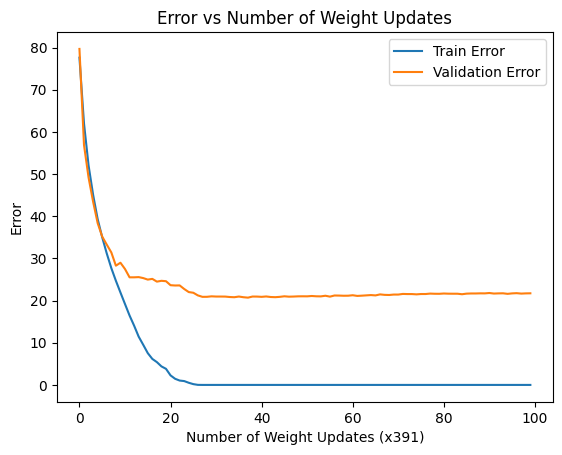

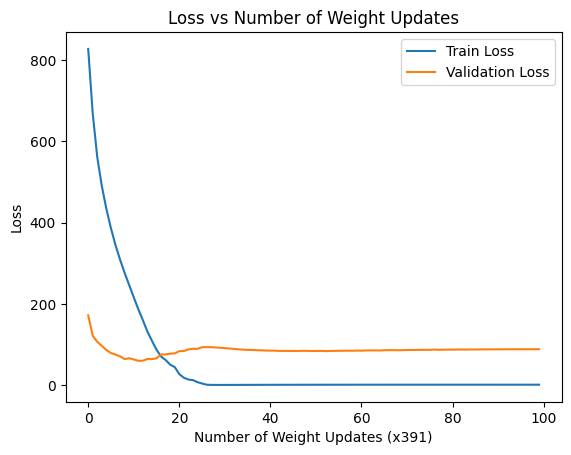

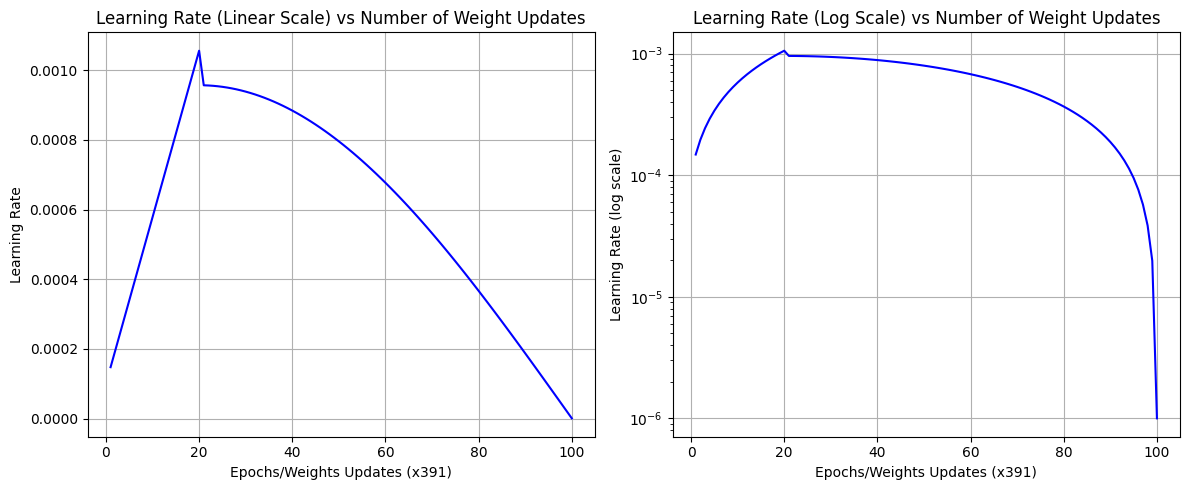

In [42]:
# Plot the learning rate, training and validation loss and error as a function of the number of weight updates.

train_error_100_eta_max = np.load(os.path.join(dir_root, 'runs/train_error_100_eta_max.npy'))
train_loss_values_100_eta_max = np.load(os.path.join(dir_root, 'runs/train_loss_values_100_eta_max.npy'))
val_error_100_eta_max = np.load(os.path.join(dir_root, 'runs/val_error_100_eta_max.npy'))
val_loss_values_100_eta_max = np.load(os.path.join(dir_root, 'runs/val_loss_values_100_eta_max.npy'))
learning_rates_100_eta_max = np.load(os.path.join(dir_root, 'runs/learning_rates_100_eta_max.npy'))

plt.figure()
plt.plot(train_error_100_eta_max, label='Train Error')
plt.plot(val_error_100_eta_max, label='Validation Error')
plt.xlabel('Number of Weight Updates (x391)')
plt.ylabel('Error')
plt.title('Error vs Number of Weight Updates')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_loss_values_100_eta_max, label='Train Loss')
plt.plot(val_loss_values_100_eta_max, label='Validation Loss')
plt.xlabel('Number of Weight Updates (x391)')
plt.ylabel('Loss')
plt.title('Loss vs Number of Weight Updates')
plt.legend()
plt.show()

epochs = np.arange(1, 101)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Linear scale
ax1.plot(epochs, learning_rates_100_eta_max, 'b-')
ax1.set_xlabel('Epochs/Weights Updates (x391)')
ax1.set_ylabel('Learning Rate')
ax1.set_title('Learning Rate (Linear Scale) vs Number of Weight Updates')
ax1.grid(True)
# Log scale
ax2.semilogy(epochs, learning_rates_100_eta_max, 'b-')
ax2.set_xlabel('Epochs/Weights Updates (x391)')
ax2.set_ylabel('Learning Rate (log scale)')
ax2.set_title('Learning Rate (Log Scale) vs Number of Weight Updates')
ax2.grid(True)

plt.tight_layout()
plt.show()

### (d)

There are heuristics in the optimization process that help pick hyper-parameters in practice. We picked the momentum parameter to be $\rho = 0.9$ in the previous two parts. We will now show experimentally that if

$$\frac{\eta_{max}}{1 - \rho}$$

is kept unchanged, the validation error more or less remains the same. You will train the network for 50 epochs and measure the validation error at the end of the 50 epochs for three settings:

(i) $\eta_{max}$ and $\rho = 0.9$

(ii) $\eta_{max} ← 5\eta_{max}$ and $\rho = 0.5$

(iii) $\eta_{max} ← \eta_{max}$ and $\rho = 0.5$

You will notice that the validation error is about the same for the first two but increases for the third setting.

Num parameters:  1667166

Training with η_max and ρ = 0.9
Epoch [1/50], Step [130/391], Loss: 1.9267
Epoch [1/50], Step [260/391], Loss: 1.7216
Epoch [1/50], Step [390/391], Loss: 1.7112
Validation Error: 71.80%
Epoch [2/50], Step [130/391], Loss: 1.5702
Epoch [2/50], Step [260/391], Loss: 1.5699
Epoch [2/50], Step [390/391], Loss: 1.5273
Validation Error: 65.51%
Epoch [3/50], Step [130/391], Loss: 1.5004
Epoch [3/50], Step [260/391], Loss: 1.4553
Epoch [3/50], Step [390/391], Loss: 1.4468
Validation Error: 59.49%
Epoch [4/50], Step [130/391], Loss: 1.4374
Epoch [4/50], Step [260/391], Loss: 1.2967
Epoch [4/50], Step [390/391], Loss: 1.3954
Validation Error: 54.98%
Epoch [5/50], Step [130/391], Loss: 1.2395
Epoch [5/50], Step [260/391], Loss: 1.2102
Epoch [5/50], Step [390/391], Loss: 1.1405
Validation Error: 53.61%
Epoch [6/50], Step [130/391], Loss: 1.1639
Epoch [6/50], Step [260/391], Loss: 1.1190
Epoch [6/50], Step [390/391], Loss: 1.2482
Validation Error: 52.22%
Epoch [7/50], Step

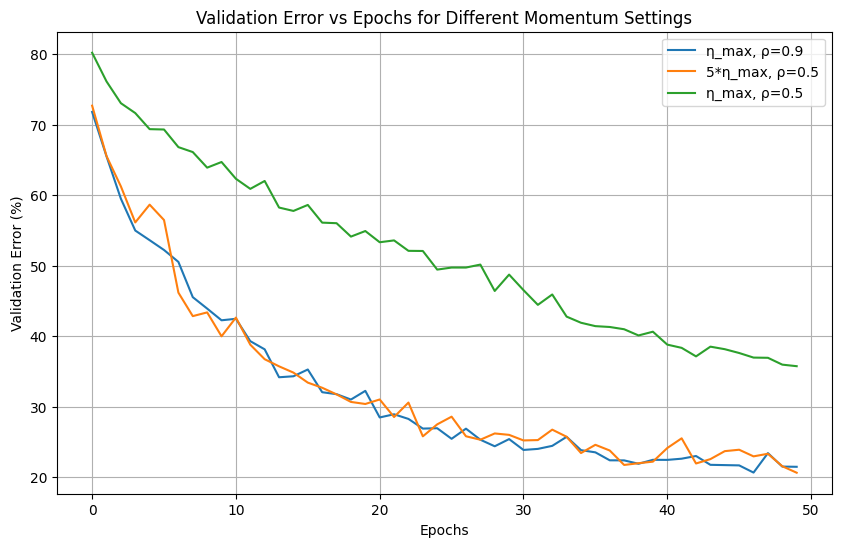


Final Validation Errors:
Setting 1 (η_max, ρ=0.9): 21.47%
Setting 2 (5*η_max, ρ=0.5): 20.63%
Setting 3 (η_max, ρ=0.5): 35.74%


In [30]:
def train_momentum(
    net, optimizer, criterion, train_loader, test_loader, epochs, model_name
):
    model = net.to(device)
    total_step = len(train_loader)
    val_error = []

    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 130 == 0:
                print(
                    f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_step}], "
                    f"Loss: {loss.item():.4f}"
                )

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            val_err = 100 - val_acc
            val_error.append(val_err)
            print(f'Validation Error: {val_err:.2f}%')

    return val_error

# Test the three settings
epochs = 50
criterion = nn.CrossEntropyLoss()

# (i) η_max and ρ = 0.9
model_1 = allcnn_t().to(device)
optimizer_1 = optim.SGD(
    model_1.parameters(),
    lr=eta_max,
    momentum=0.9,
    weight_decay=1e-3,
    nesterov=True
)

print("\nTraining with η_max and ρ = 0.9")
val_error_1 = train_momentum(
    model_1, optimizer_1, criterion, trainloader, testloader, epochs, "setting1"
)

# (ii) 5*η_max and ρ = 0.5
model_2 = allcnn_t().to(device)
optimizer_2 = optim.SGD(
    model_2.parameters(),
    lr=5*eta_max,
    momentum=0.5,
    weight_decay=1e-3,
    nesterov=True
)

print("\nTraining with 5*η_max and ρ = 0.5")
val_error_2 = train_momentum(
    model_2, optimizer_2, criterion, trainloader, testloader, epochs, "setting2"
)

# (iii) η_max and ρ = 0.5
model_3 = allcnn_t().to(device)
optimizer_3 = optim.SGD(
    model_3.parameters(),
    lr=eta_max,
    momentum=0.5,
    weight_decay=1e-3,
    nesterov=True
)

print("\nTraining with η_max and ρ = 0.5")
val_error_3 = train_momentum(
    model_3, optimizer_3, criterion, trainloader, testloader, epochs, "setting3"
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(val_error_1, label='η_max, ρ=0.9')
plt.plot(val_error_2, label='5*η_max, ρ=0.5')
plt.plot(val_error_3, label='η_max, ρ=0.5')
plt.xlabel('Epochs')
plt.ylabel('Validation Error (%)')
plt.title('Validation Error vs Epochs for Different Momentum Settings')
plt.legend()
plt.grid(True)
plt.show()

# Print final validation errors
print("\nFinal Validation Errors:")
print(f"Setting 1 (η_max, ρ=0.9): {val_error_1[-1]:.2f}%")
print(f"Setting 2 (5*η_max, ρ=0.5): {val_error_2[-1]:.2f}%")
print(f"Setting 3 (η_max, ρ=0.5): {val_error_3[-1]:.2f}%")


In [ ]:
# Shut down if it's google colab
# First sleep for a while so that changes to the notebook are saved
import time
time.sleep(60)

if 'google.colab' in str(get_ipython()):
    from google.colab import runtime
    runtime.unassign()